# Retrosheet Pre-Processing
The purpose of this sheet is to pre-process the raw Retrosheet event files rather than working with the baseball on a stick data.

In [46]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import pandas as pd
import datetime, copy, imp
import time
import os
import re
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
tqdm.pandas()

import sys
sys.path.insert(0, '../../util/')

%aimport data_cache
from data_cache import CacheResult

In [48]:
cachePathStr = '/Users/gmessier/data/baseball/cache/'
dataPathStr = '/Users/gmessier/data/baseball/'
tgtSeasons = [ 2016, 2017 ]  # The seasons that define our player population.
startSeason = 1992  # Player event start season.
endSeason = 2019 # Player event end season.
topPlayerFrc = 0.1 # Fraction of players to select as top performers.

### Target Player Roster
- The player population is every non-pitcher who was playing in the target seasons.

In [49]:
rosterFiles = [] 
for tgtSeason in tgtSeasons:
    pathStr = dataPathStr + '{}/'.format(tgtSeason)
    allFiles = os.listdir(pathStr)
    fileRegex = re.compile('ROS')
    rosterFiles += [ '{}/{}'.format(tgtSeason,x) for x in allFiles if fileRegex.search(x) ]

In [50]:
@CacheResult
def ProcessRosters(fileNames):
    rowList = []
    for fileName in tqdm(fileNames):    
        file = open(dataPathStr + fileName)        
        for line in file:
            flds = line.split(',')
            row = {
                'PlayerId': flds[0],
                'LastName': flds[1],
                'FirstName': flds[2],
                'Posn': flds[-1][0:-1],
                'Team': flds[-2]
            }
            rowList.append(row)
            
        file.close()
        
    tbl = pd.DataFrame.from_dict(rowList)
    
    # Since we mainly care about position and not team, arbitrarily keep one duplicated record.
    tbl = tbl.loc[~(tbl.PlayerId.duplicated())] 
            
    return tbl

In [51]:
rstr = ProcessRosters(rosterFiles,path=cachePathStr)

In [52]:
# Do not include pitchers in the assessment of offsensive capability.
offPlayers = rstr[rstr.Posn != 'P'].PlayerId

### Player Transactions

In [8]:
tranFileStr = '~/data/baseball/tran/tran.txt'

In [9]:
headers = [
    'PriDate', 'Time', 'ApxInd', 'SecDate', 'ApxIndSec', 'TrId',
    'Player', 'Type', 'FromTeam', 'FromLeague', 'ToTeam',
    'ToLeague', 'DftType', 'DftRnd', 'PickNo', 'Info']

types = {
    'PriDate': 'object', 'Time': 'object', 'ApxInd': 'object', 
    'SecDate': 'object', 'ApxIndSec': 'object', 'TrId': 'object',
    'Player': 'object', 'Type': 'object', 'FromTeam': 'object', 
    'FromLeague': 'object', 'ToTeam': 'object',
    'ToLeague': 'object', 'DftType': 'object', 'DftRnd': 'object', 
    'PickNo': 'object', 'Info': 'object'}

In [10]:
trnRaw = pd.read_csv(tranFileStr,sep=',',names=headers,dtype=types)

In [11]:
tranEventType = { 
    'F': 'FreeAgent', 'R': 'Released', 'D': 'Draft', 'T': 'Trade', 'W': 'Waivers', 'C': 'CndDeal', 'P': 'Purchase',
    'U': 'Unknown', 'X': 'ExpansionPick', 'M': 'MinorLeague', 'L': 'Loan', 'J': 'Jump', 'A': 'Assigned', 'V': 'LeagueCtrl',
    'Z': 'Retired', 'p': 'Purchase', np.nan: np.nan }

def TransactionTimeline(tbl):
    
    dates = pd.to_datetime(pd.DataFrame({ 
        'year': tbl.PriDate.str[:4].astype('int'), 
        'month': tbl.PriDate.str[4:6].astype('int').combine(1,max), 
        'day': tbl.PriDate.str[6:8].astype('int').combine(1,max),
        'minute': [ 1 ]*len(tbl.index)}))
    
    return pd.DataFrame({
        'Date': dates, 
        'Event': [ tranEventType[t] for t in tbl.Type.str[0] ] 
        }).sort_values('Date')

In [12]:
@CacheResult
def GenTransactionTimelines(trn):
    return trnRaw.groupby('Player').progress_apply(TransactionTimeline)

In [13]:
trn = GenTransactionTimelines(trnRaw,path=cachePathStr)
trn = trn[trn.index.get_level_values(0).isin(offPlayers)]

### Process Event Files

In [14]:
seasons = range(startSeason,endSeason+1)

In [15]:
dataPathStr = '/Users/gmessier/data/baseball/'
fileRegex = re.compile('EV(A|N)')
eventFiles = []
for season in seasons:
    pathStr = '{}{}/'.format(dataPathStr,season)
    allFiles = os.listdir(pathStr)
    for x in allFiles:
        if fileRegex.search(x):
            eventFiles.append('{}{}'.format(pathStr,x))

In [16]:
hitRegex = re.compile("^(S\d|D\d|T\d|DGR|HR|HP)"); # For now, includes being hit by a pitch.
singleRegex = re.compile("^S|^HP");
doubleRegex = re.compile("^D");
tripleRegex = re.compile("^T");
homerunRegex = re.compile("^H");
rbiRegex = re.compile("-H");
bbRegex = re.compile("^(?:IW|W(?:[^P]|$))")

In [17]:
def ProcessOffensiveEvents(eventFileStr):

    fp = open(eventFileStr)
    rowList = []

    gameStr = ''
    topBottom = [ 'Top', 'Bottom' ]

    for line in fp:
        row = {}
        flds = line.split(',')

        if flds[0] == 'id':
            gameStr = flds[1][0:-1]
            dateStr = gameStr[3:7] + '-' + gameStr[7:9] + '-' + gameStr[9:11]
            if gameStr[-1] == '0':
                curTime = pd.to_datetime(dateStr + ' 12:00')
            elif gameStr[-1] == '1':
                curTime = pd.to_datetime(dateStr + ' 15:01')
            elif gameStr[-1] == '2':
                curTime = pd.to_datetime(dateStr + ' 18:02')
            else:
                sys.exit("ERROR: Can't handle more than a triple header.")

        if flds[0] == 'start':

            entry = { 'Date': curTime, 'PlayerId': flds[1], 'Event': 'Start', 'Rbi': 0 }
            rowList.append(entry)
            
        if flds[0] == 'play':
            curTime += pd.Timedelta('1 min')
            result = flds[6][0:-1]
                            
            if hitRegex.search(result):
                entry = { 'Date': curTime, 'PlayerId': flds[3], 'Event': '', 'Rbi': len(rbiRegex.findall(result)) }

                if singleRegex.search(result):
                    entry['Event'] = '1B'
                elif doubleRegex.search(result):
                    entry['Event'] = '2B'
                elif tripleRegex.search(result):
                    entry['Event'] = '3B'
                else:
                    entry['Event'] = 'HR'

                rowList.append(entry)
                    
            if bbRegex.search(result):
                curTime += pd.Timedelta('1 min')
                entry = { 'Date': curTime, 'PlayerId': flds[3], 'Event': 'BB', 'Rbi': len(rbiRegex.findall(result)) }
                rowList.append(entry)
            
    
    return pd.DataFrame.from_dict(rowList)    
        

In [18]:
#tt = ProcessOffensiveEvents('/Users/gmessier/data/baseball/2017/2017ANA.EVA')

In [19]:
@CacheResult
def ProcessEventFiles(files):
    tbl = pd.DataFrame()
    for file in tqdm(files):
        tbl = pd.concat([ tbl, ProcessOffensiveEvents(file) ],ignore_index=True)
    return tbl    

In [20]:
evnt = ProcessEventFiles(eventFiles,path=cachePathStr)
evnt = evnt[evnt.PlayerId.isin(offPlayers)]

### Offsensive Performance

In [21]:
yhooPts = {
    '1B': 2.6, '2B': 5.2, '3B': 7.8, 'HR': 10.4, 'R': 1.9, 'RBI': 1.9, 'BB': 2.6, 'SB': 4.2, 'HBP': 2.6
}

In [22]:
def TotalGamePoints(tbl):
    points = 0
    
    points += sum(tbl.Event == '1B') * yhooPts['1B']
    points += sum(tbl.Event == '2B') * yhooPts['2B']
    points += sum(tbl.Event == '3B') * yhooPts['3B']
    points += sum(tbl.Event == 'HR') * yhooPts['HR']
    points += sum(tbl.Event == 'BB') * yhooPts['BB']

    points += tbl.Rbi.sum() * yhooPts['RBI']

    return points

In [23]:
def PlayerGamePointTotals(tbl):
    pts = tbl.groupby(tbl.Date.dt.date).apply(CalcGamePoints)
    return pd.DataFrame({
        'Date': pd.to_datetime(pts.index)+pd.Timedelta('23 hours'),
        'Points': pts
        })

In [24]:
@CacheResult
def CalcPlayerPoints(evnt):
    return evnt.groupby('PlayerId').progress_apply(PlayerGamePointTotals)

In [25]:
# Determines the total Yahoo points scored by each player on each of their game dates.
playerPts = CalcPlayerPoints(evnt,path=cachePathStr)

In [26]:
def CalcPlayerSeasonTotals(tbl):
    return tbl.groupby(tbl.Date.dt.year).apply(lambda x: sum(x.Points))

In [27]:
@CacheResult
def CalcSeasonTotals(pts):
    return pts.groupby(level=0).progress_apply(CalcPlayerSeasonTotals)

In [28]:
# Determines the total points scored by each player in a season.
seaTtls = CalcSeasonTotals(playerPts,path=cachePathStr)

In [29]:
def CalcTopPlayerCutoff(tbl,cutoffFrc):
    years = tbl.index.get_level_values(1).unique().sort_values()
    cutoffs = []
    for year in years:
        nPlayers = len(tbl.loc[:,year])
        cutoffs.append(tbl.loc[:,year].sort_values().iloc[int(nPlayers*(1-cutoffFrc))])
    return pd.Series(cutoffs,index=years)

In [30]:
# The cutoffs in each season to be in the top topPlayerFrc of players.
topThsh = CalcTopPlayerCutoff(seaTtls,topPlayerFrc)

In [31]:
def FindTopPlayerEvents(tbl,thresholds):
    years = tbl.Date.dt.year.unique()
    eventDates = []
    for year in years:
        seasn = tbl[tbl.Date.dt.year == year]
        cumPts = seasn.Points.cumsum()
        if cumPts.iloc[-1] > thresholds[year]:
            eventDates.append(seasn.loc[cumPts > thresholds[year]].Date.min())
    return pd.DataFrame({'Date': eventDates, 'Event': [ 'TopPlayer' ]*len(eventDates)})

In [32]:
@CacheResult
def FindTopPlayers(playerPts,thresholds):
    return playerPts.groupby(level=0).progress_apply(FindTopPlayerEvents,thresholds=topThsh)

In [75]:
# Produce a time stamped table of when/if a player breaks into the top topPlayerFrc
evntTop = FindTopPlayers(playerPts,topThsh,path=cachePathStr)

### Merge Major Events and Transaction Events

In [65]:
def PlayerMajorEvents(tbl):
    return tbl.loc[tbl.Event.isin(['Start','HR'])][['Date','Event']]

In [68]:
#PlayerMajorEvents(evnt.loc[evnt.PlayerId == 'abrej003'])

In [69]:
@CacheResult
def MajorEvents(evnt):
    return evnt.groupby('PlayerId').progress_apply(PlayerMajorEvents)

In [70]:
evntMjr = MajorEvents(evnt,path=cachePathStr)

  0%|          | 0/874 [00:00<?, ?it/s]

In [90]:
tbl = pd.concat([ trn, evntMjr, evntTop ])
tbl = tbl.groupby(level=0).progress_apply(lambda x: x.sort_values(by=['Date'],ignore_index=True))

  0%|          | 0/915 [00:00<?, ?it/s]

### Save Data

In [96]:
baseballDataFileStr = '/Users/gmessier/data/baseball/2019SeasonClassification.hdf'
tbl.to_hdf(baseballDataFileStr,key='Features',mode='w')

In [97]:
translate = { 
    'FreeAgent': 'Referral', 'Start': 'Stay', 'HR': 'MajorEvent', 
    'Released': 'Referral', 'Draft': 'Referral', 'Trade': 'Referral',
    'Waivers': 'Referral', 'CndDeal': 'Referral', 'Purchase': 'Referral',
    'TopPlayer': 'AdverseOutcome'
}

In [98]:
tblGeneric = tbl.replace(translate)

In [99]:
baseballDataFileStr = '/Users/gmessier/data/baseball/2019GenericData.hdf'
tblGeneric.to_hdf(baseballDataFileStr,key='Features',mode='w')

In [100]:
tblGeneric.Event.unique()

array(['Referral', 'Stay', 'MajorEvent', 'AdverseOutcome'], dtype=object)

<AxesSubplot:>

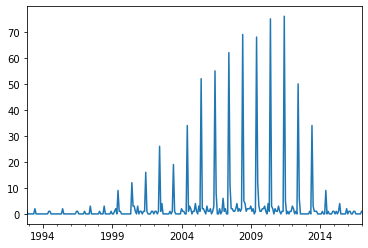

In [102]:
entryDates = trn.groupby(level=0).apply(lambda x: x.Date.min())
entryDateCount = pd.Series(range(len(entryDates)),index=entryDates).resample('1M').count()
entryDateCount.plot()